In [1]:
'''
IMPORTS
'''

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from collections import Iterable
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp
from random import choice
import matplotlib.cm as cm

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [159]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id,colony_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = (ant_id,colony_id)
        
    def random_walk(self,source,sink,system=0):
        #Random Walk
        #initialize method
        self.source=source
        self.sink=sink
        self.system=system
        self.g=self.get_space()
        
        
        #initialize needed global data for heuristic
        self.capacity_list=self.get_capacity_list(self.system)
        
        for u,v in self.g.edges():
            capacity_pheromone_list=self.get_pheromone_capacity((u,v),self.system)
            capacity_to_add=self.capacity_list[self.make_decision(capacity_pheromone_list)]
            self.g[u][v]['capacity']=capacity_to_add
        
        #print self.g.nodes()
        #print nx.get_edge_attributes(space.g,'capacity')
        
        out_graph=self.prune_graph(self.g,self.sink,self.source)
        #print nx.get_edge_attributes(out_graph,'capacity')
        #print (self.ant_id,float(self.ant_id[0]-1)/(space.num_ants-1)), steps
        #print out_graph.nodes()
        #print out_graph.edges()
        return (out_graph) #(self.g)
    
    def prune_graph(self,graph,sinks,sources):
        """
        Removes nodes that only go out and back.
        """
        done=0
        for u,v in self.g.edges():
            if self.g[u][v]['capacity']==0:
                #print 'removed no capacity edge', (u,v)
                self.g.remove_edge(u,v)
        
        #print graph.nodes()
        #print graph.edges()
        
        while not done:
            done=1
            for n in graph:
                if graph.out_degree(n)==0 and graph.in_degree(n)==0: #disconnected nodes
                    #print 'removed disconnected node', n
                    done=0
                    break
                    
                if graph.in_degree(n)>0 and graph.out_degree(n)==0 and (n not in sinks): #dead end, non-sink nodes
                    #print 'removed dead end node', n
                    done=0
                    break
                
                
                if (graph.out_degree(n)==1) and (graph.in_degree(n)==1) and (n not in sinks or sources): #there and back non-critical nodes
                    neighbor=graph.neighbors(n)
                    if n in graph.neighbors(neighbor[0]):
                        #print 'removed cul de sac node', n
                        done=0
                        break
            if done==0:
                #print n
                #print graph.nodes()
                graph.remove_node(n)
        
        #print graph.nodes()
        #print graph.edges()
        return graph
                
    def get_space(self):
        return copy.deepcopy(self.model.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    def get_capacity_list(self,system):
        """
        Returns the capacity list from the space
        """
        return self.model.capacities[system]
    
    def get_pheromone_capacity(self,edge,system):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge,self.ant_id,system)
    
       
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [199]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size=[3,3],num_ants=2,num_colonies=1,
                 source=[[(0,0)],[(1,1)]],source_magnitude=[[5],[5]],
                 sink=[[(1,1)],[(1,1)]],sink_magnitude=[[5],[5]], sink_threshold=[[1.0],[1.0]],
                 links=[(1,0,(1,1))],capacities=[[0,5,10],[0,5]],edge_capacity=20, percent_removals=.5,
                 dissipation=.2,initial_pheromone=1.0,):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        #System A
        self.sink = sink
        self.sink_magnitude = sink_magnitude
        self.sink_threshold= sink_threshold #at what point is the sink not functioning
        self.source=source
        self.source_magnitude = source_magnitude
        self.links=links #(recieving_system,sending_system,node)
        
        #Ants
        self.num_ants=num_ants
        self.num_colonies=num_colonies
        self.dissipation=dissipation
        self.initial_pheromone=initial_pheromone
        self.capacities=capacities
        self.percent_removals=percent_removals
        self.edge_capacity=edge_capacity
        
        
        # Set our state variables
        self.t = 0
        self.ants = []
        self.ant_graphs=[]
        #self.global_scores=[]

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        
    def flatten(self,lis):
         for item in lis:
            if isinstance(item, Iterable) and not isinstance(item, basestring):
                for x in self.flatten(item):
                    yield x
            else:        
                yield item
                
    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=self.size)
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print 'Setting up network'
        capacity_pheromone_list=[[],[]]
        for i in xrange(2):
            capacity_pheromone_list[i]=[0.1]*(len(self.capacities[i])-1)
            capacity_pheromone_list[i].append(0.1)
            capacity_pheromone_list[i].reverse()
            print capacity_pheromone_list[i]
            capacity_pheromone_list[i]=capacity_pheromone_list[i]*2
            print capacity_pheromone_list[i]
        
        capacity_pheromone_list=list(self.flatten(capacity_pheromone_list))
        print capacity_pheromone_list
        
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],max_capacity=self.edge_capacity)
            self.g.add_edge(e[0],e[1],capacity=0) #initial capacity 
            self.g.add_edge(e[0],e[1],capacity_pheromone=capacity_pheromone_list) #pheromone per capacity

        print nx.get_edge_attributes(self.g,'capacity_pheromone')
        
        self.g_layout = nx.spectral_layout(self.g)
 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """       
        # First, begin by creating all ants.
        int_id=0 #set up list ID of ants
        self.ant_id_dict={} #set up dict converting ant id to list id
        for c in xrange(self.num_colonies):
            for i in xrange(self.num_ants):
                self.ants.append(Ant(model=self,ant_id=(i+1),colony_id=(c+1)))
                self.ant_id_dict[(i,c)]=int_id                
                int_id+=1
        #print self.ant_id_dict
    
    def split_lists(self,input_list):
        half = len(input_list)/2
        return input_list[:half], input_list[half:]
           
    
    def get_capacity_pheromone(self,edge,ant_id,system):
        """
        Get capacity decision pheromone for ant call
        """  
        ant_weight=float(ant_id[0]-1)/(self.num_ants-1)
        pheromone_full=self.g[edge[0]][edge[1]]['capacity_pheromone']
        system_pheromones=[[],[]]
        system_pheromones[0]=pheromone_full[:len(self.capacities[0])*2]
        system_pheromones[1]=pheromone_full[len(self.capacities[0])*2:]
        pheromone_1, pheromone_2=self.split_lists(system_pheromones[system])
        
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]
        
        return composite_pheromone
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id,system):
        """
        Get the path of an ant based on their ID.
        """
        ant_list_id=self.ant_id_dict[ant_id]
        return self.ants[ant_list_id].random_walk(self.source[system],self.sink[system],system)
    
    def flow_test(self,graph):
        """
        Calculates the flow from sources to sinks in a graph.
        
        """
        flow_graph_1=copy.deepcopy(graph[0])
        flow_graph_2=copy.deepcopy(graph[1])
        
        #print 'Pre flow graph capacity 1'
        #print nx.get_edge_attributes(flow_graph_1,'capacity')
        #print 'Pre flow graph capacity 2'
        #print nx.get_edge_attributes(flow_graph_2,'capacity')
        
        #print self.sink[0]
        for i in xrange(len(self.sink[0])):
            #print self.sink[0][i]
            flow_graph_1.add_edge(self.sink[0][i],'sink',capacity=self.sink_magnitude[0][i])
            #print flow_graph[g][self.sink[g][i]]['sink']
        
        #print self.sink[1]
        for i in xrange(len(self.sink[1])):
            #print self.sink[1][i]
            flow_graph_2.add_edge(self.sink[1][i],'sink',capacity=self.sink_magnitude[1][i])
        
        #add aggregate source
        
        
        #print self.source[0]
        flow_graph_1.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source[0])):
            #print self.source[0][i]
            flow_graph_1.add_edge('source',self.source[0][i],capacity=self.source_magnitude[0][i])
            
        #print self.source[1]
        flow_graph_2.add_node('place_holder') #fixes indexing error in maximum_flow
        for i in xrange(len(self.source[1])):
            #print self.source[1][i]
            flow_graph_2.add_edge('source',self.source[1][i],capacity=self.source_magnitude[1][i])
        
        flow_graph=[flow_graph_1,flow_graph_2]
        #print 'Post flow graph capacity 1'
        #print nx.get_edge_attributes(flow_graph[0],'capacity')
        #print 'Post flow graph capacity 2'
        #print nx.get_edge_attributes(flow_graph[1],'capacity')
        flow=[]
        while True:
            #get flow values
            flow_value=[[],[]]
            flow_dict=[[],[]]
            flow_value[0], flow_dict[0] = nx.maximum_flow(flow_graph[0], 'source', 'sink')
            flow_value[1], flow_dict[1] = nx.maximum_flow(flow_graph[1], 'source', 'sink')
            flow.append(flow_value)
            #print 'flow_value',flow
            #print 'flow dict 1', flow_dict[0]
            #print 'flow dict 2', flow_dict[1]
            
            for link in self.links:
                receiving=link[0] #system recieving flow
                sending=link[1] #system sending flow
                node=link[2]
                sending_node_index=self.sink[sending].index(node)
                #print sending_node_index,self.sink[sending][sending_node_index],node
                sending_flow=flow_dict[sending][node]['sink']
                sending_threshold=float(self.sink_magnitude[sending][sending_node_index])*self.sink_threshold[sending][sending_node_index]
                
                failure=0
                if sending_flow < sending_threshold: #sink fails and linked source fails
                    #print 'cascading failure'
                    failure=1
                    flow_graph[receiving]['source'][node]['capacity']=0
                    #print flow_graph[receiving]['source'][node]['capacity']
            if failure==0 or (len(flow)>=2 and (flow[-1]==flow[-2])):
                #print 'cascade over'
                break
                                       
        
        return flow_value, flow_dict
    
    def graph_energy(self,graph):
        """
        Calculates the energy of a system graph.
        """
        e_val, e_vec=numpy.linalg.eig(nx.adjacency_matrix(graph.to_undirected()).todense())
    
        return sum(abs(e_val))
    
    
    def complexity_score(self,graph):
        """
        Calculates the complexity of two system graph.
        """
        #base_energy=[self.graph_energy(graph[0]),self.graph_energy(graph[1])]
        sys_complexity_edge=0
        for u,v in self.g.edges():
            temp_graph=copy.deepcopy(graph)
            edge_energy=[]
            #get max_cap from space (there and back are the same)
            edge_max=space.g[u][v]['max_capacity']
            #get cap from sys_1
            edge_cap=0
            num_sys_edge=0
            for g_index in xrange(2):
                #get capacity in edge
                sys_cap=0
                if temp_graph[g_index].has_edge(u,v):
                    sys_cap+=graph[g_index][u][v]['capacity']
                    temp_graph[g_index].remove_edge(u,v)
                    num_sys_edge+=1
                #if temp_graph[g_index].has_edge(v,u):
                    #sys_cap+=graph[g_index][v][u]['capacity']
                    #temp_graph[g_index].remove_edge(v,u)
                edge_cap+=sys_cap
                
                #calculate edge complexity
                #edge_energy.append(abs(base_energy[g_index]-self.graph_energy(temp_graph[g_index])))
            
            cap_difference=float(edge_cap)/edge_max
            if num_sys_edge>0:           
                edge_complexity=edge_cap*2**(cap_difference*num_sys_edge) #edge_energy[0]+edge_energy[1]
            else:
                edge_complexity=0
            #print (u,v,edge_complexity,edge_energy,cap_difference)    
            sys_complexity_edge+=edge_complexity
            
        sys_complexity_node=0
        for n in self.g:
            num_sys_node=0
            edge_in=0
            edge_out=0
            for g_index in xrange(2):
                if n in graph[g_index]:
                    num_sys_node+=1
                    edge_in+=graph[g_index].in_degree(n)
                    edge_out+=graph[g_index].out_degree(n)
            if num_sys_node>0:
                node_complexity=(edge_in+edge_out)*2**num_sys_node
            else:
                node_complexity=0
            sys_complexity_node+=node_complexity
            
        sys_complexity=sys_complexity_node+sys_complexity_edge
        #sys_complexity=graph[0].number_of_edges()+graph[1].number_of_edges()+(graph[0].number_of_nodes()+graph[1].number_of_nodes())
        
        
        return sys_complexity
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
                
        #Score 1 - Flow        
        #get initial flow values
        flow_value_ini,flow_dict_ini=self.flow_test(ant_graph)
        #print flow_value_ini
        #print sum(self.sink_magnitude[0]),sum(self.sink_magnitude[1])
        
        flow_score_ini=[]
        for g_index in xrange(2):
            flow_score_ini.append(float(flow_value_ini[g_index])/sum(self.sink_magnitude[g_index]))
        #print 'flow_score',flow_score_ini
        satisfy_flow=flow_score_ini
        #if (flow_score_ini[0]!=1 or flow_score_ini[1]!=1):
            #satisfy_flow=0
            #print 'flow failure'
            #return (0,0),satisfy_flow
        
        #percolate and test flow
        percolation_graph=copy.deepcopy(ant_graph)
        space_graph = nx.grid_graph(dim=self.size)
        space_graph=space_graph.to_directed()
        base_percolation_graph=[]
        for g in xrange(2):
            base_percolation_graph.append(nx.compose(space_graph,percolation_graph[g]))
        #num_removals=int(numpy.rint(self.percent_removals*ant_graph.number_of_edges()))
        num_removals=int(numpy.rint(base_percolation_graph[0].number_of_edges()*self.percent_removals))
        
        survivability_flow=0
        survivability_function=0
        num_trials=10
        for i in xrange(num_trials):
            percolation_graph=copy.deepcopy(base_percolation_graph)
            for j in xrange(num_removals):
                edge_removed=choice(percolation_graph[0].edges())
                for g_index in xrange(2):
                    percolation_graph[g_index].remove_edge(edge_removed[0],edge_removed[1])
                    percolation_graph[g_index].remove_edge(edge_removed[1],edge_removed[0])
                    
                #Check if there is a cascade and iterate.    
                flow_increment,flow_dict=self.flow_test(percolation_graph)
                function_increment=0
                for g_index in xrange(2):
                    for sink_index in xrange(len(self.sink[g_index])):
                        sink_flow=flow_dict[g_index][self.sink[g_index][sink_index]]['sink']
                        sink_threshold=self.sink_magnitude[g_index][sink_index]*self.sink_threshold[g_index][sink_index]                         
                        function_increment+=(sink_flow>=sink_threshold)
                    
                        #print survivability_function
                if function_increment==0:
                    #print 'Failed'
                    break
                else:
                    survivability_function+=function_increment

        #flow is judged by the amount of flow that gets to the aggregate sink based on the total sink magnitude
        num_sinks=len(self.sink_magnitude[0])+len(self.sink_magnitude[1])
        #print num_sinks,num_removals,num_trials
        if num_removals==0:
            survivability_score_function=1
        else:
            survivability_score_function=float(survivability_function)/(num_sinks*num_removals*num_trials)
        #survivability_score_flow=float(survivability_flow)/(sum(self.sink_magnitude)*num_removals*num_trials)
        survivability_score_function*=(flow_score_ini[0]*flow_score_ini[1])
        #Score 2 - Complexity
        complexity_score=self.complexity_score(ant_graph)
        if flow_score_ini[0]*flow_score_ini[1]==0:
            complexity_score*=1000
        else:
            complexity_score*=1/(flow_score_ini[0]*flow_score_ini[1])
        
        return (survivability_score_function,complexity_score),satisfy_flow
    
    def dominates(self, point_1, point_2, equality_sequence):
        '''
        Calculates if a point is dominated by another point, used in simple_cull_front
        equality_sequence:= 1 is '>=',0 is '<='
        '''
        score=0
        for i in range(len(point_1)):
            if equality_sequence[i]==1 and point_1[i]>=point_2[i]:
                score+=1
            elif equality_sequence[i]==0 and point_1[i]<=point_2[i]:
                score+=1
        dom=score==len(point_1)    
        return dom    
   
    def simple_cull_front(self, inputPoints, dominates, equality_sequence):
        '''
        Basic algorithm to find the pareto front of a set of points
        min or max is determined based on equality_sequence:= 0 is min, 1 is max
        '''
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if self.dominates(candidateRow, row,equality_sequence):
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif self.dominates(row, candidateRow, equality_sequence):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        num_ants_generation=self.num_ants*self.num_colonies
        #[score_list.append(graph[1]) for graph in ant_graphs[-num_ants_generation:]] #Generation Pareto
        [score_list.append(graph[1]) for graph in ant_graphs] #Global Pareto
        cull_scores=score_list[:]
        equality_sequence=[1,0] #[>=,<=]
        self.paretoPoints, self.dominatedPoints=self.simple_cull_front(cull_scores,self.dominates,equality_sequence)
        self.paretoPoints=list(self.paretoPoints)

        best_ants_index=[]
        
        #match the score_list indices to the pareto front values
        for i in xrange(len(score_list)):
            if score_list[i] in self.paretoPoints:
                best_ants_index.append(i)
                #print 'pareto score @',i,':',score_list[i]
                
        return best_ants_index, score_list
    
    def pheromone_dissipation(self,pheromone_list,dissipation):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        return_list=[]
        for i in xrange(len(pheromone_list)):
            return_list.append(pheromone_list[i]*(1.0-dissipation))
        #print return_list
        return return_list
    
    def pheromone_update_capacity(self,pheromone_list,increment,system,index):
        """
        Updates a pheromone list with the proper increment based on system number.
        """
        sys_list=[[],[]]
        sys_list[0]=pheromone_list[:len(self.capacities[0])*2]
        sys_list[1]=pheromone_list[len(self.capacities[0])*2:]
        pheromone_1, pheromone_2=self.split_lists(sys_list[system])
        objective_sys_list=[[[],[]],[[],[]]]
        for sys in xrange(2):
            objective_sys_list[sys][0],objective_sys_list[sys][1]=self.split_lists(sys_list[sys])
        #print 'original list',pheromone_list
        #print 'decomposed list', objective_sys_list
        #print 'increment',increment
        #print 'index to increment', index
        #print 'system', system
        
        for obj in xrange(2):
            objective_sys_list[system][obj][index]+=increment[obj]
            #print 'adjusted list for objective', obj,':',objective_sys_list
        return_list=list(self.flatten(objective_sys_list))
        #print return_list
        return return_list
        
    
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_graphs=[] #exclude for initialized in setup for global pareto front
        
        #Step for each ant
        failures=0
        for c in xrange(self.num_colonies):
            print 'colony:',c
            for i in xrange(self.num_ants):
                sat_flow=0
                ant_failures=0
                while sat_flow==0:
                    self.ant_graph=[[],[]]
                    for g in xrange(2):
                        self.ant_graph[g]=self.get_path((i,c),g)
                        #print 'Initial flow graph capacity', g
                        #print nx.get_edge_attributes(self.ant_graph[g],'capacity')
                    
                    #self.ant_graph_1=self.get_path((i,c),0)
                    #print 'Initial flow graph capacity', 1
                    #print nx.get_edge_attributes(self.ant_graph_1,'capacity')
                    #self.ant_graph_2=self.get_path((i,c),1)
                    #print 'Initial flow graph capacity', 2
                    #print nx.get_edge_attributes(self.ant_graph_2,'capacity')
                    
                    #self.ant_graph=[self.ant_graph_1,self.ant_graph_2]
                        
                    #print 'After pull flow graph capacity 1'
                    #print nx.get_edge_attributes(self.ant_graph[0],'capacity')
                    #print 'After pull flow graph capacity 2'
                    #print nx.get_edge_attributes(self.ant_graph[1],'capacity')
       
                        

                    #Evaluate Paths
                    self.graph_score,sat_flow=self.evaluate_graph(self.ant_graph)
                    #if sat_flow==0:
                        #failures+=1
                        #ant_failures+=1
                    #print sat_flow

                #List <graph,score>
                self.ant_graphs.append((self.ant_graph,self.graph_score))
                print (i,c), sat_flow
                #print 'got one'
        
        print failures    
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        
        
        #Update Institutions - Edges and capacities for this walk
        #Get pheromones
        self.capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')

        
        #print self.termination_pheromone_dict
        #print nx.get_edge_attributes(self.g,'capacity_pheromone')
        #Reduce edge pheromones by input amount
        for key in self.capacity_pheromone_dict:
            self.capacity_pheromone_dict[key]=self.pheromone_dissipation(self.capacity_pheromone_dict[key],
                                                                         self.dissipation)
        #print nx.get_edge_attributes(self.g,'capacity_pheromone')
        #Increment through best paths to update
        #for ph_index in xrange(2):
        for ant in self.opt_ant:
            for sys in xrange(2):
                pheromone_increment=[self.score_list[ant][0],1.0/len(self.opt_ant)]#self.score_list[ant][1]
                for e in self.ant_graphs[ant][0][sys].edges():
                    #get capacity chosen and update pheromones
                    self.capacity_chosen=self.ant_graphs[ant][0][sys][e[0]][e[1]]['capacity']
                    self.capacity_index=self.capacities[sys].index(self.capacity_chosen)
                    #print self.capacity_chosen, self.capacity_index
                    
                    self.capacity_pheromone_dict[e]=self.pheromone_update_capacity(self.capacity_pheromone_dict[e],
                                                                                   pheromone_increment,sys,
                                                                                   self.capacity_index)
                    #print self.capacity_pheromone_dict[e]


        #Remove all except for pareto front ants
        #keep_ants=[]
        #for i in range(len(self.ant_graphs)):
            #if i in self.opt_ant:
                #keep_ants.append(self.ant_graphs[i])
                
        #self.ant_graphs=keep_ants
        #print len(self.ant_graphs), 'length of kept graphs'
        

        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', self.capacity_pheromone_dict)


Setting up network
[0.1, 0.1, 0.1]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[0.1, 0.1]
[0.1, 0.1, 0.1, 0.1]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
{((2, 1), (3, 1)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((1, 0), (2, 0)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((0, 3), (1, 3)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((0, 2), (1, 2)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((1, 1), (2, 1)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((1, 1), (1, 2)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((2, 0), (2, 1)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((2, 0), (1, 0)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((0, 1), (0, 0)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((2, 1), (2, 2)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((0, 0), (1, 0)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((1, 2), (2, 2)): [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], ((2, 1), (

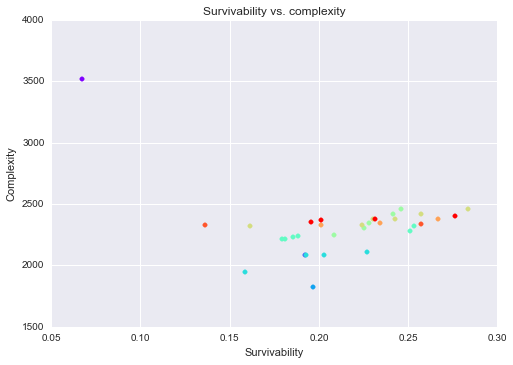

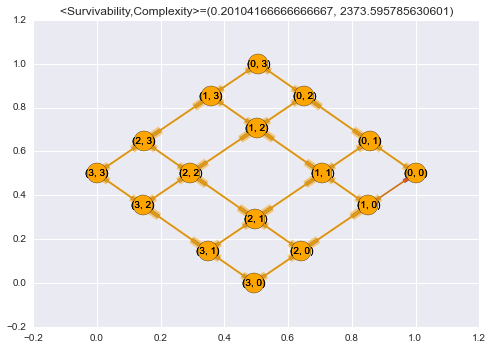

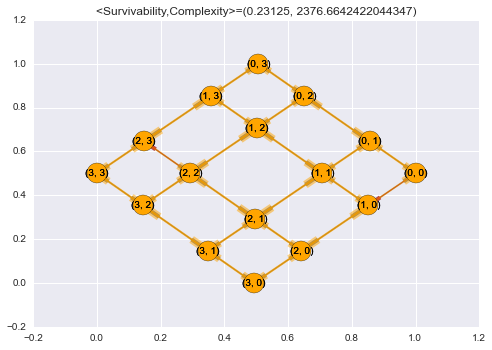

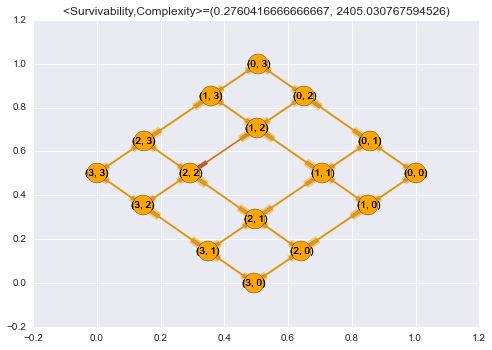

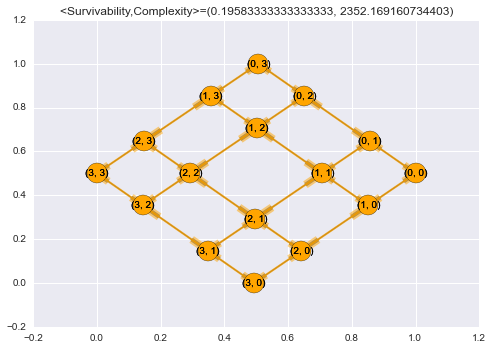

In [200]:
'''
Run Example
'''

#space=Space()


space=Space(size=[4,4],num_ants=10,num_colonies=10,
            source=[[(0,0)],[(3,3)]],source_magnitude=[[20],[10]],
            sink=[[(3,3),(1,3)],[(0,0),(2,0)]],sink_magnitude=[[10,10],[5,5]], sink_threshold=[[.5,1.0],[1.0,1.0]],
            links=[(1,0,(3,3))],capacities=[[0,7,10],[0,5]],edge_capacity=20,percent_removals=.50,
            dissipation=0.2,initial_pheromone=1.0)

#space=Space(size=[5,5],num_ants=10,num_colonies=10,
            #source=[[(0,0)],[(4,4)]],source_magnitude=[[20],[20]],
            #sink=[[(4,4),(1,3),(4,0)],[(0,0),(2,0),(4,0),(4,1)]],sink_magnitude=[[5,10,5],[5,5,5,5]], 
            #sink_threshold=[[.5,1.0,.25,1.0],[.75,1.0,.5,1.0]],
            #links=[(1,0,(4,4))],capacities=[[5,10,20],[5,10,20]],edge_capacity=50,percent_removals=.50,
            #dissipation=0.2,initial_pheromone=1.0,)

#space=Space(size=[5,5,3],num_ants=10,num_colonies=10,source=[[(0,3,0),(0,1,0)],[20,20]],
            #sink=[[(3,2,2),(1,4,2),(4,4,2),(3,4,0)],[10,10,15,5]],
            #initial_pheromone=1,beta=2.0,capacities=[5,10,15,20])
converged=0
i=1
pareto_history=[]
criteria=0
while not converged:
    space.step()
    print 'Pareto front of generation',i,':',space.paretoPoints #'\r',
    pareto_history.append(space.paretoPoints)
    if i>5 and pareto_history[-1]==pareto_history[-2]:
        criteria+=1
    else:
        criteria=0
    #print criteria
    if criteria>3:
        converged=1
    
    #print '\r',i,',',
    i+=1
    if i>10:
        converged=1
        print '\n'
        

print('Ant Path')

    

# Remove the nonpath from path nodes
#nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

# Now we can visualize the infected node's position
#visualize_system(space.ant_graphs[space.opt_ant[-1]][0],space.g,space.paretoPoints[-1])

#Plot Solutions
#front_x=[i[0] for i in space.paretoPoints]
#front_y=[i[1] for i in space.paretoPoints]
#dominated_x=[i[0] for i in space.dominatedPoints]
#dominated_y=[i[1] for i in space.dominatedPoints]
f = plt.figure()
#plt.scatter(dominated_x,dominated_y,alpha=0.5)
#plt.scatter(front_x,front_y,color='red',alpha=1)

colors = cm.rainbow(numpy.linspace(0, 1, len(pareto_history)))
#print colors
for gen, c in zip(pareto_history, colors):
    x=[i[0] for i in gen]
    y=[i[1] for i in gen]
    #print c
    plt.scatter(x, y, color=c)

plt.xlabel("Survivability")
plt.ylabel("Complexity")
plt.title("Survivability vs. complexity")

for i in xrange(len(space.opt_ant)):
    score=space.paretoPoints[i]
    visualize_system_single(space.ant_graphs[space.opt_ant[i]][0],space.g,score)


In [175]:
def visualize_system_single(system,area,score):
    #system=system_list[index]
    
    # Remove the nonpath from path nodes
    path_nodes=[[],[]]
    for i in xrange(2):
        path_nodes[i] = [node for node in area.nodes() if node in system[i]]
    
    nonpath_nodes = [node for node in area.nodes() if node not in system[0] or node not in system[1]]
    
    # Removed shared nodes
    shared_nodes=[]
    for n in area.nodes():
        if n in path_nodes[0] and n in path_nodes[1]:
            shared_nodes.append(n)
            path_nodes[0].remove(n)
            path_nodes[1].remove(n)
    
    # Remove edges
    path_edges=[[],[]]
    for i in xrange(2):
        path_edges[i]=system[i].edges()
        
    # Remove shared edges
    shared_edges=[]
    for e in area.edges():
        if e in path_edges[0] and e in path_edges[1]:
            shared_edges.append(e)
            path_edges[0].remove(e)
            path_edges[1].remove(e)
    
    
    area_layout=nx.spectral_layout(area)
    # Now we can visualize the infected node's position
    f = plt.figure()

    nx.draw_networkx_nodes(area, area_layout,
                           nodelist=nonpath_nodes,
                           node_color='#dddddd')
    
    nx.draw_networkx_nodes(system[0], area_layout, 
                           nodelist=path_nodes[0],
                           node_color='red')
    
    nx.draw_networkx_nodes(system[1], area_layout, 
                           nodelist=path_nodes[1],
                           node_color='blue')
    
    nx.draw_networkx_nodes(system[0], area_layout, 
                           nodelist=shared_nodes,
                           node_size=400,
                           node_color='orange')

    nx.draw_networkx_edges(area, area_layout, 
                           width=1.0, 
                           alpha=0.5,
                           edge_color='#111111')

    nx.draw_networkx_edges(system[0], area_layout,
                          edgelist=path_edges[0],
                          width=1.0, 
                          alpha=0.5,
                          edge_color='red')
    
    nx.draw_networkx_edges(system[1], area_layout,
                          edgelist=path_edges[1],
                          width=1.0, 
                          alpha=0.5,
                          edge_color='blue')
    
    nx.draw_networkx_edges(system[0], area_layout,
                          edgelist=shared_edges,
                          width=2.0, 
                          alpha=0.5,
                          edge_color='orange')

    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    _ = nx.draw_networkx_labels(area, area_layout,
                            dict(zip(area.nodes(), area.nodes())),
                            font_size=10)
    
    plt.title('<Survivability,Complexity>={}'.format(score))

In [10]:
G=nx.path_graph(4)
print G.nodes()
G.remove_edge(2,3)
print G.nodes()
print G.edges()

[0, 1, 2, 3]
[0, 1, 2, 3]
[(0, 1), (1, 2)]


In [17]:
l=[0]*4
l.append(1)
print l*2

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [181]:
print nx.get_edge_attributes(space.g,'capacity_pheromone')

{((2, 1), (3, 1)): [2.2300745198530677e-06, 0.23750223007451984, 0.5198139674118651, 2.2300745198530677e-06, 0.33333556340785314, 0.6666889674118652, 2.2300745198530677e-06, 0.5198139674118651, 2.2300745198530677e-06, 0.6666889674118652], ((1, 0), (2, 0)): [2.2300745198530677e-06, 2.2300745198530677e-06, 0.5198139674118651, 2.2300745198530677e-06, 2.2300745198530677e-06, 0.6666889674118652, 2.2300745198530677e-06, 0.7573139674118652, 2.2300745198530677e-06, 1.0000223007451985], ((0, 3), (1, 3)): [2.2300745198530677e-06, 2.2300745198530677e-06, 0.7573139674118652, 2.2300745198530677e-06, 2.2300745198530677e-06, 1.0000223007451985, 2.2300745198530677e-06, 0.7573139674118652, 2.2300745198530677e-06, 1.0000223007451985], ((0, 2), (1, 2)): [2.2300745198530677e-06, 2.2300745198530677e-06, 0.7573139674118652, 2.2300745198530677e-06, 2.2300745198530677e-06, 1.0000223007451985, 2.2300745198530677e-06, 0.7573139674118652, 2.2300745198530677e-06, 1.0000223007451985], ((1, 1), (2, 1)): [2.23007451